In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import os
import time
IMAGES_FOLDER_PATH = "../images"

In [2]:
noisy = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'noisy_lena.png'),0)

In [3]:
def Recursive1DFFT(arr):
    n = arr.shape[0]
    if n==1:
        return arr

    if np.log2(n)-int(np.log2(n)) != 0.0:
        padding = 2**(int(np.log2(n))+1) - n
        arr = np.append(arr, np.zeros(padding))
        
    n = arr.shape[0]
    arr_even = arr[0:n:2]
    arr_odd = arr[1:n:2]
    
    y_even = Recursive1DFFT(arr_even)
    y_odd = Recursive1DFFT(arr_odd)
    
    E = np.array(np.exp((-2*np.pi*np.complex(0,1)*np.array(range(int(n/2))))/n))
    
    y= []
    y = y_even + E * y_odd
    y = np.append(y, y_even - E * y_odd)
    
    return y

In [4]:
def Recursive2DFFT(arr):
    Y = np.zeros(arr.shape,dtype='complex')
    h,w = arr.shape
    
    for i in range(h):
        Y[i,:] = Recursive1DFFT(arr[int(i),:])[:w]
    Y_copy = np.copy(Y)
    for i in range(w):
        Y[:,i] = Recursive1DFFT(Y_copy[:,int(i)])[:h]
    
    return Y

In [5]:
def IFFT2D(X):
    h,w = X.shape
    
    x = np.zeros(X.shape,dtype='complex')
    
    for i in range(h):
        x[i,:] = np.conj(Recursive1DFFT(np.conj(X[int(i),:]))[:w])/w
    x_copy = np.copy(x)
    for i in range(w):
        x[:,i] = np.conj(Recursive1DFFT(np.conj(x_copy[:,int(i)]))[:h])/h
        
    return x/h*w

In [6]:
def blurring_mean(img,k):
    h,w = img.shape
    
    output = np.zeros([h,w])
    
    padding_img = np.zeros([h+k-1,w+k-1],dtype='int64')
    padding_img[int((k-1)/2):int(h+(k-1)/2),int((k-1)/2):int(w+(k-1)/2)] = img
    
    kernel = np.ones([k,k])
    
    kernel = kernel/sum(sum(kernel))
    
    for i in range(int((k-1)/2),h+int((k-1)/2)):
        for j in range(int((k-1)/2),w+int((k-1)/2)):     
            area_obs = padding_img[i-int((k-1)/2):i+int((k-1)/2)+1,j-int((k-1)/2):j+int((k-1)/2)+1].reshape(k,k)  
            output[i-int((k-1)/2)][j-int((k-1)/2)] = int(sum(sum(kernel*area_obs)))
    
    return output

In [7]:
dft = Recursive2DFFT(noisy)
orig = dft

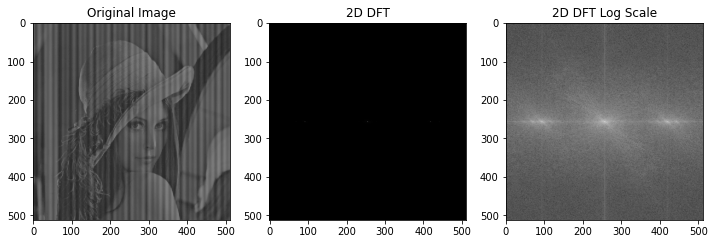

In [8]:
plt.figure(figsize =(12,10))
plt.subplot(131)
plt.imshow(noisy,cmap='gray')
plt.title('Original Image')
plt.subplot(132)
plt.imshow(np.abs(np.fft.fftshift(dft)).astype('int64'),cmap='gray')
plt.title('2D DFT')
plt.subplot(133)
plt.imshow(np.log(1+np.abs(np.fft.fftshift(dft))).astype('int64'),cmap='gray')
plt.title('2D DFT Log Scale')
plt.show()

In [9]:
dft = np.fft.fftshift(dft)
# temp = np.zeros(dft.shape,dtype='complex')
# temp[100:400,200:300] = dft[100:400,200:300]
# dft = temp

In [10]:
dft = np.fft.fftshift(dft)
ifft  = IFFT2D(dft)

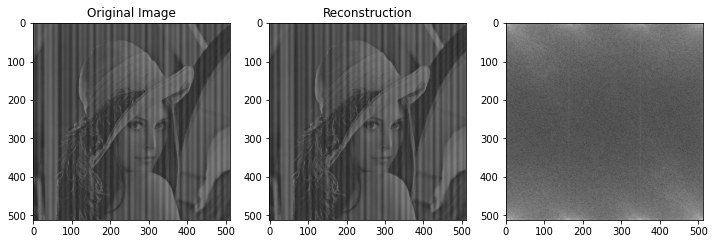

In [11]:
plt.figure(figsize =(12,10))
plt.subplot(131)
plt.imshow(noisy,cmap='gray')
plt.title('Original Image')
plt.subplot(132)
plt.imshow(np.real(ifft).astype('int64'),cmap='gray')
plt.title('Reconstruction')
plt.subplot(133)
plt.imshow(np.log(1+np.abs(dft)).astype('int64'),cmap='gray')
# plt.title('Reconstruction')
plt.show()

In [25]:
dft = np.fft.fftshift(orig)
# dft[:,70:120]=np.sum(dft[:,70:120])/np.product(dft[:,70:120].shape)
# dft[:,400:450]=np.sum(dft[:,400:450])/np.product(dft[:,400:450].shape)
dft[:,50:130]/=20
# dft[:,250:260]/=10
dft[:,390:470]/=20
dft[240:270,50:130]/=10
dft[240:270,390:470]/=10
# dft[:,90:100]/=2
# dft[:,410:420]/=2
# dft[:,93] = 0

dft = np.fft.fftshift(dft)
ifft  = IFFT2D(dft)

In [26]:
reconstruct = np.real(ifft).astype('int64')
reconstruct = blurring_mean(reconstruct,3)

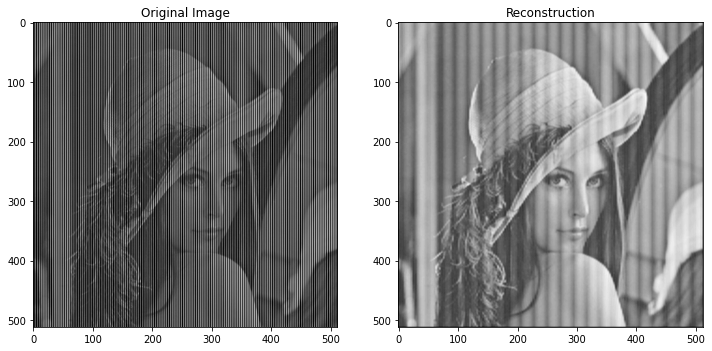

In [27]:
plt.figure(figsize =(12,10))
plt.subplot(121)
plt.imshow(noisy,cmap='gray')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(reconstruct,cmap='gray')
plt.title('Reconstruction')
plt.show()

#### I see that the Frequency Domain representation has a lot of points along X-axes which have a higher intensity. There may be the reason for the vertical lines along the picture. I reduce their intensity and use mean filtering to get a better reconstructed image

In [28]:
# plt.figure(figsize =(12,10))
# plt.subplot(121)
# plt.imshow(np.log(1+np.abs(np.fft.fftshift(dft))).astype('int64'),cmap='gray')
# plt.title('2D DFT')
# plt.subplot(122)
# plt.imshow(np.log(1+np.abs(np.fft.fftshift(lena_dft))).astype('int64'),cmap='gray')
# plt.title('2D DFT Log Scale')
# plt.show()

In [29]:
# plt.figure(figsize =(12,10))
# plt.subplot(121)
# plt.imshow(noisy,cmap='gray')
# plt.title('Original Image')
# plt.subplot(122)
# plt.imshow(np.real(ifft).astype('int64'),cmap='gray')
# plt.title('Reconstruction')
# plt.show()

In [33]:
# px.imshow(np.log(1+np.abs(np.fft.fftshift(dft))).astype('int64'),color_continuous_scale='gray').show()

In [31]:
# lena = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'lena.jpg'),0)

# lena_dft = np.fft.fft2(lena)

# plt.figure(figsize =(12,10))
# plt.subplot(131)
# plt.imshow(lena,cmap='gray')
# plt.title('Original Image')
# plt.subplot(132)
# plt.imshow(np.abs(np.fft.fftshift(lena_dft)).astype('int64'),cmap='gray')
# plt.title('2D DFT')
# plt.subplot(133)
# plt.imshow(np.log(1+np.abs(np.fft.fftshift(lena_dft))).astype('int64'),cmap='gray')
# plt.title('2D DFT Log Scale')
# plt.show()